In [68]:
import pandas as pd
import numpy as np

In [69]:
# Load the training data
train_df = pd.read_csv('Train.csv')

In [70]:
# Shape of training data
print(f" Shape: {train_df}")

 Shape:        Unnamed: 0                                               TEXT  Label
0               0  Vacation wasted ! #vacation2017 #photobomb #ti...      0
1               1  Oh Wynwood, you’re so funny! : @user #Wynwood ...      1
2               2  Been friends since 7th grade. Look at us now w...      2
3               3  This is what it looks like when someone loves ...      3
4               4  RT @user this white family was invited to a Bl...      3
...           ...                                                ...    ...
69995       69995  Yes, I call Galina "my Bubie" Go follow my bea...      3
69996       69996    I SEA you, Seattle @ Ballard Seafood Festival\n     16
69997       69997  If one of my daughters is wearing this and ask...      2
69998       69998  Guess who whoop people on THEIR homecoming?! #...      3
69999       69999  We Love you Robbie @ Heritage Memorial Cemeter...     14

[70000 rows x 3 columns]


In [71]:
# First 5 rows
print(train_df.head())

   Unnamed: 0                                               TEXT  Label
0           0  Vacation wasted ! #vacation2017 #photobomb #ti...      0
1           1  Oh Wynwood, you’re so funny! : @user #Wynwood ...      1
2           2  Been friends since 7th grade. Look at us now w...      2
3           3  This is what it looks like when someone loves ...      3
4           4  RT @user this white family was invited to a Bl...      3


In [72]:
# Load the mapping data
mapping_df = pd.read_csv('Mapping.csv')
print(mapping_df.head())

   Unnamed: 0 emoji  Label
0           0     😜      0
1           1     📸      1
2           2     😍      2
3           3     😂      3
4           4     😉      4


In [73]:
# Rename columns to align for merging
mapping_df = mapping_df.rename(columns={'number': 'Label', 'emoticons': 'emoji'})

In [74]:
# Merge label → emoji mapping into train_df
train_df = train_df.merge(mapping_df[['Label', 'emoji']], on='Label')

# Preview of the new dataframe
print(train_df.head())

   Unnamed: 0                                               TEXT  Label emoji
0           0  Vacation wasted ! #vacation2017 #photobomb #ti...      0     😜
1           1  Oh Wynwood, you’re so funny! : @user #Wynwood ...      1     📸
2           2  Been friends since 7th grade. Look at us now w...      2     😍
3           3  This is what it looks like when someone loves ...      3     😂
4           4  RT @user this white family was invited to a Bl...      3     😂


In [75]:
import re

# Define a cleaning function
def clean_text(text):
    text = text.lower()                                # Lowercase
    text = re.sub(r'@[\w_]+', '', text)                # Remove @mentions
    text = re.sub(r'#(\w+)', r'\1', text)              # Remove # but keep the word
    text = re.sub(r'http\S+', '', text)                # Remove links
    text = re.sub(r'[^\w\s]', '', text)                # Remove punctuation
    text = re.sub(r'\d+', '', text)                    # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()           # Remove extra whitespace
    return text

# Apply cleaning
train_df['clean_text'] = train_df['TEXT'].apply(clean_text)

# Preview
train_df[['TEXT', 'clean_text']].head()


,TEXT,clean_text
0,Vacation wasted ! #vacation2017 #photobomb #ti...,vacation wasted vacation photobomb tired vacat...
1,"Oh Wynwood, you’re so funny! : @user #Wynwood ...",oh wynwood youre so funny wynwood art itwasam ...
2,Been friends since 7th grade. Look at us now w...,been friends since th grade look at us now we ...
3,This is what it looks like when someone loves ...,this is what it looks like when someone loves ...
4,RT @user this white family was invited to a Bl...,rt this white family was invited to a black ba...


### We ran a code which cleaned each tweet in the TEXT column by removing mentions, hashtags, links, punctuation, numbers, and extra spaces, and saves the result in a new column called clean_text. ✅

In [76]:
# Clean dataframe 
train_df.head()

,Unnamed: 0,TEXT,Label,emoji,clean_text
0,0,Vacation wasted ! #vacation2017 #photobomb #ti...,0,😜,vacation wasted vacation photobomb tired vacat...
1,1,"Oh Wynwood, you’re so funny! : @user #Wynwood ...",1,📸,oh wynwood youre so funny wynwood art itwasam ...
2,2,Been friends since 7th grade. Look at us now w...,2,😍,been friends since th grade look at us now we ...
3,3,This is what it looks like when someone loves ...,3,😂,this is what it looks like when someone loves ...
4,4,RT @user this white family was invited to a Bl...,3,😂,rt this white family was invited to a black ba...


In [77]:
train_df.drop(columns=['TEXT'], inplace=True)


In [78]:
train_df.head()

,Unnamed: 0,Label,emoji,clean_text
0,0,0,😜,vacation wasted vacation photobomb tired vacat...
1,1,1,📸,oh wynwood youre so funny wynwood art itwasam ...
2,2,2,😍,been friends since th grade look at us now we ...
3,3,3,😂,this is what it looks like when someone loves ...
4,4,3,😂,rt this white family was invited to a black ba...


### Now we'll convert text to numbers. We'll->
##### 1)Convert the cleaned text into numeric sequences using Tokenizer

##### 2)Pad those sequences so they’re all the same length

##### 3)Convert the emoji Label column into categorical one-hot labels for training


In [79]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set a vocabulary size
vocab_size = 5000
oov_token = "<OOV>"

# Create and fit tokenize
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_token)
tokenizer.fit_on_texts(train_df['clean_text'])

# Converting text to sequences 
sequences = tokenizer.texts_to_sequences(train_df['clean_text'])

# Pad the sequences to same length 
max_length = max(len(seq) for seq in sequences)
padded_sequence = pad_sequences(sequences, maxlen = max_length, padding = 'post')

In [80]:
import os
# ... (your existing code that calculates max_length)

# Create project directory if it doesn't exist (important!)
os.makedirs("project", exist_ok=True)

# Save max_length
with open("project/max_length.txt", "w") as f:
    f.write(str(max_length))
print(f"Max length ({max_length}) saved to project/max_length.txt")

Max length (33) saved to project/max_length.txt


In [81]:
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vectors

embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [82]:
# One-Hot Encode the Labels

from tensorflow.keras.utils import to_categorical

# Check how many unique labels you have 
num_classes = train_df['Label'].nunique()
print(f"Number of classes : {num_classes}")

one_hot_labels = to_categorical(train_df['Label'], num_classes=num_classes)


Number of classes : 20


In [83]:
# This will show you all 20 emoji–label pairs being used in the dataset
train_df[['Label', 'emoji']].drop_duplicates().sort_values('Label')


,Label,emoji
0,0,😜
1,1,📸
2,2,😍
3,3,😂
5,4,😉
6,5,🎄
7,6,📷
9,7,🔥
10,8,😘
11,9,❤


In [84]:
from sklearn.utils import class_weight


# Calculate class weights
# 'balanced' mode automatically computes weights inversely proportional
# to class frequencies, giving more weight to minority classes.
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['Label']), # Get all unique labels
    y=train_df['Label']                   # Pass the actual labels
)
class_weights_dict = dict(enumerate(class_weights)) # Convert array to dictionary format

print("\nCalculated Class Weights:")
print(class_weights_dict)


Calculated Class Weights:
{0: np.float64(2.24791265253693), 1: np.float64(1.3503086419753085), 2: np.float64(0.4946297343131713), 3: np.float64(0.5115463314820228), 4: np.float64(1.8636847710330138), 5: np.float64(1.770359129994942), 6: np.float64(1.6802688430148824), 7: np.float64(0.8022003208801284), 8: np.float64(1.7570281124497993), 9: np.float64(0.23192631369690545), 10: np.float64(2.0337013364323067), 11: np.float64(1.437962202136401), 12: np.float64(1.8334206390780514), 13: np.float64(1.0769230769230769), 14: np.float64(1.4944491887275833), 15: np.float64(0.9107468123861566), 16: np.float64(1.2358757062146892), 17: np.float64(1.272264631043257), 18: np.float64(2.032520325203252), 19: np.float64(2.005730659025788)}


In [85]:
# ... (your previous imports, data loading, cleaning, tokenizing, padding, etc. remain the same)

# Build the LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, Dropout # Make sure to import Bidirectional and Dropout

model = Sequential(
    [
        Input(shape=(max_length,)), # Input layer defines the shape of your padded sequences
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim, # This will be 100 if you're using glove.6B.100d.txt
            weights=[embedding_matrix], # Initialize with your GloVe embedding matrix
            trainable=False # Keep this False for now to leverage pre-trained knowledge
        ),
        # --- START OF NEW/REVISED ARCHITECTURE ---
        Bidirectional(LSTM(128, return_sequences=True)), # First BiLSTM layer. 'return_sequences=True' is needed when stacking LSTMs.
        Dropout(0.8),                                   # Dropout to prevent overfitting (can be 0.2 to 0.5)
        Bidirectional(LSTM(64)),                        # Second BiLSTM layer. 'return_sequences=False' (default) for the last LSTM before Dense.
        Dropout(0.8),                                   # Another Dropout layer
        # --- END OF NEW/REVISED ARCHITECTURE ---
        Dense(num_classes, activation='softmax')        # Output layer for 20 emoji classes
    ]
)

# Compiling (this part remains the same)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary (this part remains the same)
print("\nModel Summary after architectural changes:")
model.summary()



Model Summary after architectural changes:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 33, 100)        │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 33, 256)        │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 33, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 901,428 (3.44 MB)

 Trainable params: 401,428 (1.53 MB)

 Non-trainable params: 500,000 (1.91 MB)

In [86]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss', # Monitor validation loss
    patience=10,        # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity.
)

In [87]:
# Train the Model
print("\nTraining Model with Bidirectional LSTMs and Dropout...")
history = model.fit(
    padded_sequence,
    one_hot_labels,
    epochs=50, # Increased epochs from 10. You can try 20-50 based on results.
    batch_size=32,
    verbose=1,
    validation_split=0.2,
    class_weight=class_weights_dict, # Ensure this is passed if you have class imbalance
    callbacks=[early_stopping]
)


Training Model with Bidirectional LSTMs and Dropout...
Epoch 1/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 151s 78ms/step - accuracy: 0.0863 - loss: 2.9345 - val_accuracy: 0.1603 - val_loss: 2.7428
Epoch 2/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 82s 47ms/step - accuracy: 0.1427 - loss: 2.7559 - val_accuracy: 0.1882 - val_loss: 2.6959
Epoch 3/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 74s 42ms/step - accuracy: 0.1588 - loss: 2.6840 - val_accuracy: 0.1810 - val_loss: 2.6727
Epoch 4/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 65s 37ms/step - accuracy: 0.1663 - loss: 2.6564 - val_accuracy: 0.1859 - val_loss: 2.6398
Epoch 5/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 71s 40ms/step - accuracy: 0.1732 - loss: 2.6227 - val_accuracy: 0.1788 - val_loss: 2.6162
Epoch 6/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 63s 36ms/step - accuracy: 0.1767 - loss: 2.5937 - val_accuracy: 0.1739 - val_loss: 2.6048
Epoch 7/50
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 62s 35ms/step - accuracy: 0.1762 - loss: 2.5731 - val_accuracy: 0.1794 - val_loss: 2.6100
Epoch 8/50
1750/175

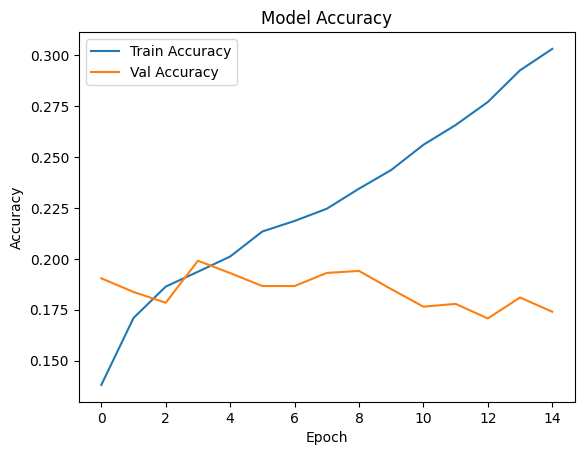

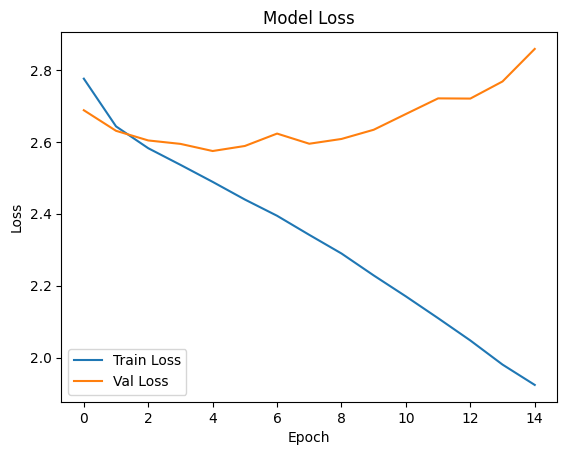

In [58]:
# To visually understand training behavior:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [59]:
# Prediction Time!
def predict_emoji(text):
    # Clean the input just like training data
    cleaned = clean_text(text)

    # Convert to sequence using same tokenizer
    seq = tokenizer.texts_to_sequences([cleaned])

    # Pad to same length as training
    padded = pad_sequences(seq, maxlen=max_length, padding='post')

    # Predict
    prediction = model.predict(padded, verbose=0)    
    # Get index of highest probability
    pred_label = prediction.argmax(axis=1)[0]

    # Get corresponding emoji from mapping_df
    emoji = mapping_df[mapping_df['Label'] == pred_label]['emoji'].values[0]

    return emoji


In [60]:
predict_emoji(" i am tired ")




'😂'

In [61]:
mapping_df.head()

,Unnamed: 0,emoji,Label
0,0,😜,0
1,1,📸,1
2,2,😍,2
3,3,😂,3
4,4,😉,4


In [62]:
import os
os.makedirs("project", exist_ok=True)


In [63]:
# Save trained model
model.save("project/emoji_model.keras") 


In [64]:
# Save tokenizer
import pickle
with open("project/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [65]:
# Save label mapping
mapping_df.to_csv("project/Mapping.csv", index=False)

In [66]:
label_counts = train_df['Label'].value_counts().sort_index()
print(label_counts)
# And look at the generated bar plot

Label
0      1557
1      2592
2      7076
3      6842
4      1878
5      1977
6      2083
7      4363
8      1992
9     15091
10     1721
11     2434
12     1909
13     3250
14     2342
15     3843
16     2832
17     2751
18     1722
19     1745
Name: count, dtype: int64
